In [32]:
import pandas as pd
import numpy as np
import openfe
from sklearn.metrics import roc_auc_score, accuracy_score, root_mean_squared_error, root_mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, KFold
from ktools.fitting.cross_validation_executor import CrossValidationExecutor
from ktools.modelling.create_oof_from_model import create_oofs_from_model
from ktools.modelling.ktools_models.catboost_model import CatBoostModel
from ktools.utils.data_science_pipeline_settings import DataSciencePipelineSettings
from functools import reduce

from dataclasses import dataclass
import os
from scipy.stats import ks_2samp
from typing import Dict, List
from ktools.fitting.cross_validation_executor import CrossValidationExecutor
from ktools.modelling.ktools_models.lgbm_model import LGBMModel
from ktools.preprocessing.basic_feature_transformers import *
from ktools.utils.data_science_pipeline_settings import DataSciencePipelineSettings
import ydf

In [30]:
sample_sub = pd.read_csv('/Users/yuwei-1/Documents/projects/Kaggle-tools/data/insurance/sample_submission.csv', index_col=0)
sample_sub['Premium Amount'] = np.expm1(pd.read_csv("/Users/yuwei-1/Downloads/ag_nonlog_fe_test.csv")['WeightedEnsemble_L3'].values)#np.expm1(pd.read_csv('data/insurance/oofs/basic_fe_CAT_GBM_XGB_RF_XT_FASTAI_test.csv', index_col=0).values)
sample_sub
sample_sub.to_csv('WeightedEnsemble_L3_submission.csv')

In [31]:
sample_sub

,Premium Amount
id,
1200000,755.030183
1200001,758.477199
1200002,754.423334
1200003,754.423334
1200004,741.257635
...,...
1999995,767.149980
1999996,739.841721
1999997,757.919719


In [20]:
for i in range(5):
    test_df = pd.read_csv(f'/Users/yuwei-1/Downloads/flaml_fold_{i}_test_pred (1).csv', index_col=0)
    oof_df = pd.read_csv(f'/Users/yuwei-1/Downloads/flaml_fold_{i}_oofs (1).csv', index_col=0)

    if i == 0:
        test_pred = np.zeros(test_df.shape[0])
        oof_pred = np.zeros(oof_df.shape[0])
    
    print(oof_pred[oof_df.values.squeeze() > 0].sum())
    assert oof_pred[oof_df.values.squeeze() > 0].sum() == 0

    test_pred += test_df.values.squeeze()/5
    oof_pred += oof_df.values.squeeze()

0.0
0.0
0.0
0.0
0.0


In [21]:
test_pred

array([6.7693314 , 6.76713157, 6.754299  , ..., 6.77530138, 6.77490376,
       6.88633764])

In [22]:
oof_pred

array([6.89666219, 6.7204988 , 6.75337862, ..., 5.26985825, 6.82746039,
       5.40159451])

In [24]:
pd.Series(test_pred).to_csv("data/insurance/oofs/flaml_1xog_test.csv")

In [25]:
pd.Series(oof_pred).to_csv("data/insurance/oofs/flaml_1xog_oof.csv")

In [10]:
y = np.log1p(pd.read_csv('/Users/yuwei-1/Documents/projects/Kaggle-tools/data/insurance/train.csv')['Premium Amount']).values

In [23]:
root_mean_squared_error(y, oof_pred)

1.028104845864841

In [12]:
oof_pred

array([6.83425434, 6.62851728, 6.7637168 , ..., 5.26922367, 6.78104908,
       5.33925526])

In [15]:
vals = np.zeros((5, 1))

In [18]:
pd.DataFrame({"0" : vals.flatten()})

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [14]:
sample_sub = pd.read_csv('/Users/yuwei-1/Documents/projects/Kaggle-tools/data/insurance/sample_submission.csv', index_col=0)
sample_sub['Premium Amount'] = np.expm1(test_pred)#np.expm1(pd.read_csv('data/insurance/oofs/basic_fe_CAT_GBM_XGB_RF_XT_FASTAI_test.csv', index_col=0).values)
sample_sub
sample_sub.to_csv('flaml_openfe.csv')

In [3]:
df = pd.read_csv('cat_fe_lg_oof_feat_submission.csv', index_col=0)
df['Premium Amount'] = np.expm1(df['Premium Amount'])
df.to_csv("cat_fe_lg_oof_feat_submission.csv")
df

,Premium Amount
id,
1200000,820.839022
1200001,903.320104
1200002,839.520209
1200003,792.533686
1200004,776.288564
...,...
1999995,985.762843
1999996,761.438542
1999997,890.025685


In [36]:
train_csv_path = "/Users/yuwei-1/Documents/projects/Kaggle-tools/data/insurance/train.csv"
original_csv_path = "/Users/yuwei-1/Documents/projects/Kaggle-tools/data/insurance/original.csv"
test_csv_path = "/Users/yuwei-1/Documents/projects/Kaggle-tools/data/insurance/test.csv"
sample_sub_csv_path = "/Users/yuwei-1/Documents/projects/Kaggle-tools/data/insurance/sample_submission.csv"
target_col_name = "Premium Amount"

In [8]:
def original_process_func(df):
    df['Vehicle Age'] = df['Vehicle Age'].astype(float)
    df['Insurance Duration'] = df['Insurance Duration'].astype(float)
    df = df[~df[target_col_name].isna()]
    return df

In [41]:
from copy import deepcopy

from sklearn.preprocessing import OrdinalEncoder


class CreateDateTimeColumns():
    @staticmethod
    def transform(original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        settings.combined_df['year'] = pd.to_datetime(settings.combined_df['Policy Start Date']).dt.year
        settings.combined_df['month'] = pd.to_datetime(settings.combined_df['Policy Start Date']).dt.month
        settings.combined_df['day'] = pd.to_datetime(settings.combined_df['Policy Start Date']).dt.day
        settings.training_col_names += ['year', 'month', 'day']
        return settings

class LogTransformTarget():
    @staticmethod
    def transform(original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        settings.combined_df[settings.target_col_name] = np.log1p(settings.combined_df[settings.target_col_name])
        return settings

class AddHealthScoreAsCat():
    @staticmethod
    def transform(original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        settings.categorical_col_names += ['Health Score']
        settings.combined_df[settings.categorical_col_names] = settings.combined_df[settings.categorical_col_names].astype(str)
        return settings
    
class OrdinalEncode():
    @staticmethod
    def transform(original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        train_df, test_df = settings.update()
        ordinal_encoder = OrdinalEncoder(encoded_missing_value=-1, handle_unknown="use_encoded_value", unknown_value=-1)
        train_df[settings.categorical_col_names] = ordinal_encoder.fit_transform(train_df[settings.categorical_col_names])
        test_df[settings.categorical_col_names] = ordinal_encoder.transform(test_df[settings.categorical_col_names])
        settings.combined_df = pd.concat([train_df, test_df], keys=['train', 'test'])
        return settings
    
class CreateYuweiFeatures():

    @staticmethod
    def transform(original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)

        df = settings.combined_df


        cat_cols = [col for col in df.columns if df[col].dtype == 'object']
        
        df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
        df['Days Passed'] = (df['Policy Start Date'].max() - df['Policy Start Date']).dt.days
        df['numYear'] = df['Policy Start Date'].dt.year
        num_day = df['Policy Start Date'].dt.day
        df['numMonth'] = df['Policy Start Date'].dt.month
        
        df['catMonth_name'] = df['Policy Start Date'].dt.month_name()
        df['catDay_of_week'] = df['Policy Start Date'].dt.day_name()
        
        df['numWeek'] = df['Policy Start Date'].dt.isocalendar().week
        
        df['numYear_sin'] = np.sin(2 * np.pi * df['numYear'])
        # df['numYear_cos'] = np.cos(2 * np.pi * df['numYear'])
        df['numMonth_sin'] = np.sin(2 * np.pi * df['numMonth'] / 12) 
        df['numMonth_cos'] = np.cos(2 * np.pi * df['numMonth'] / 12)
        # df['numDay_sin'] = np.sin(2 * np.pi * df['numDay'] / 31)  
        # df['numDay_cos'] = np.cos(2 * np.pi * df['numDay'] / 31)
        df['numGroup']=(df['numYear']-2020)*48+df['numMonth']*4+num_day//7
        df['contract length'] = pd.cut(df["Insurance Duration"].fillna(99),  
        bins=[-float('inf'), 1, 3, float('inf')], labels=[0, 1, 2]).astype(int)
        
        print("done initial time features")

        cat_cols += ['catMonth_name', 'catDay_of_week']
        temp = [x for x in cat_cols if x not in ['Location', 
                                                 'Education Level', 
                                                 'Policy Type', 
                                                 'Smoking Status',
                                                 'Marital Status',
                                                 'Exercise Frequency',
                                                 'Gender', 
                                                 'Occupation', 
                                                 'catMonth_name', 
                                                 'Property Type', 
                                                 'catMonth_name']]
        for col in temp:
            print(f"frequency encoding col: {col}")
            freq_encoding = df[col].value_counts().to_dict()

            new_col_name = f"{col}_freq"
            df[new_col_name] = df[col].map(freq_encoding)
            df[new_col_name] = df[col].map(freq_encoding)

            cat_cols += [new_col_name]


        num_cols = [col for col in df.columns if col not in cat_cols]
        df[cat_cols] = df[cat_cols].fillna('None').astype(str).astype('category')
        df[num_cols] = df[num_cols].fillna(0).astype(float)


        df['cat_annual_income'] = df['Annual Income'].astype(str).astype('category')
        # df['cat_number_of_dependents'] = df['Number of Dependents'].astype(str).astype('category')
        df['cat_health_score'] = df['Health Score'].astype(str).astype('category')
        # df['cat_previous_claims'] = df['Previous Claims'].astype(str).astype('category')
        df['cat_credit_score'] = df['Credit Score'].astype(str).astype('category')
        # df['cat_insurance_duration'] = df['Insurance Duration'].astype(str).astype('category')
        # df['catMissingValuesCount'] = df.isna().sum(axis=1).astype(str).astype('category')
        # df['catMissingHealth'] = df['Health Score'].isna().astype(str).astype('category')

        # df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])    
        
        # df['catYear'] = df['Policy Start Date'].dt.year
        # df['catMonth'] = df['Policy Start Date'].dt.month
        # df['catDay'] = df['Policy Start Date'].dt.day

        df['catHealth vs Claims'] = df['Health Score'] / (df['Previous Claims'] + 2)
        # df['catClaims v Duration'] = df['Previous Claims'] / df['Insurance Duration']
        # df['Cat Credit Score'] = df['Credit Score'].copy()
        df['catInt Credit Score'] = df['Credit Score'].apply(lambda x: int(x) if pd.notna(x) else x)
        df['HealthScore'] = df['Health Score'].apply(lambda x: int(x) if pd.notna(x) else x)

        # df['HealthScore'] = df['Health Score'].apply(lambda x: int(x) if pd.notna(x) else x)
        
        settings.categorical_col_names += [
                                            'catHealth vs Claims',
                                            'catInt Credit Score'
                                            # 'catMissingValuesCount',
                                            # 'catMissingHealth',
                                            # 'catClaims v Duration'
                                            # 'Health Score',
                                            # 'Previous Claims',
                                            # 'Cat Credit Score'
                                        ]
        # df = df.drop(columns='Policy Start Date')
        # settings.categorical_col_names.remove('Policy Start Date')
        
        df[settings.categorical_col_names] = df[settings.categorical_col_names].astype(str)
        settings.combined_df = df
        return settings
    

class NonLogFeature():

    @staticmethod
    def transform(original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        train_df, test_df = settings.update()
        test_df.drop(columns=[settings.target_col_name], inplace=True)
        X, y = train_df.drop(columns=settings.target_col_name), train_df[[settings.target_col_name]]

        kf = KFold(5, shuffle=True, random_state=42)

        score_tuple, nonlog_oof_predictions, model_list = CrossValidationExecutor(CatBoostModel(predict_type="else"),
                                                                            root_mean_squared_error,
                                                                            kf,
                                                                            verbose=2
                                                                            ).run(X, y)
        test_preds = np.zeros(test_df.shape[0])
        for model in model_list:
            test_preds += model.predict(test_df)/kf.get_n_splits()

        train_df['oof'] = nonlog_oof_predictions
        test_df['oof'] = test_preds
        settings.combined_df = pd.concat([train_df, test_df], keys=['train', 'test'])
        return settings
    

class TransformMultiClass():

    @staticmethod
    def transform(original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        settings.combined_df[settings.target_col_name] = np.log1p(settings.combined_df[settings.target_col_name])//1
        settings.combined_df[settings.target_col_name] = settings.combined_df[settings.target_col_name].astype(int, errors='ignore')
        return settings

In [16]:
from ktools.experimentation.robust_feature_importance_checker import RobustFeatureImportanceChecker


kf = KFold(5, shuffle=True, random_state=42)
checker = RobustFeatureImportanceChecker(train_csv_path,
                                        test_csv_path,
                                        target_col_name,
                                        OpenFEFeatureCreator(),
                                        kf,
                                        root_mean_squared_error,
                                        metric_direction = "minimize",
                                        model_params={'objective': 'regression', 'metric': 'rmse'},
                                        result_path="ktools/experimentation/Tests/TestData/insurance",
                                        initial_transform_list = [FillNullValues.transform,
                                                                #   CreateDataTimeColumns.transform,
                                                                  LogTransformTarget.transform,
                                                                  ConvertObjectToCategorical.transform],
                                        sqrt_population_size = 6
                                        )

checker.run()

Initial population found
####################################################################################################
OOF prediction score :  1.0517957502526079
Mean 5-cv results : 1.0517951792870008 +- 0.001095937075015716
####################################################################################################
####################################################################################################
OOF prediction score :  1.0518319152375366
Mean 5-cv results : 1.0518290859953643 +- 0.0024396242377354876
####################################################################################################
####################################################################################################
OOF prediction score :  1.0517459440729502
Mean 5-cv results : 1.0517442455148727 +- 0.0018902116951503907
####################################################################################################
#################################################

In [42]:
settings = DataSciencePipelineSettings(train_csv_path,
                                        test_csv_path,
                                        target_col_name, 
                                        # original_csv_path=original_csv_path,
                                        # original_csv_processing=original_process_func
                                        )
transforms = [
            # LogTransformTarget.transform,
            FillNullValues.transform,
            # CreateYuweiFeatures.transform,
            ConvertObjectToCategorical.transform,
            TransformMultiClass.transform
            # NonLogFeature.transform,
            # LogTransformTarget.transform,
            ]

settings = reduce(lambda acc, func: func(acc), transforms, settings)
settings.update()

train, test_df = settings.update()
test_df.drop(columns=[target_col_name], inplace=True)
X, y = train.drop(columns=target_col_name), train[[target_col_name]]

In [49]:
y.nunique()

Premium Amount    6
dtype: int64

In [51]:
kf = KFold(5, shuffle=True, random_state=42)

score_tuple, mae_log_oofs, model_list = CrossValidationExecutor(CatBoostModel(num_boost_round = 100, predict_type="class", loss_function="MultiClass", eval_metric="Accuracy"),
                                                                    accuracy_score,
                                                                    kf,
                                                                    verbose=2,
                                                                    num_classes=1
                                                                    ).run(X, y)

The CV results of the current fold is 0.4838625
The CV results of the current fold is 0.4847875
The CV results of the current fold is 0.48355
The CV results of the current fold is 0.4835291666666667
The CV results of the current fold is 0.48532916666666664
####################################################################################################
OOF prediction score :  0.48421166666666665
Mean 5-cv results : 0.48421166666666665 +- 0.0007219302828759338
####################################################################################################


In [53]:
kf = KFold(5, shuffle=True, random_state=42)

score_tuple, mae_log_oofs, model_list = CrossValidationExecutor(CatBoostModel(predict_type="else",
                                                                              loss_function = 'MAE'),
                                                                    mean_absolute_error,
                                                                    kf,
                                                                    verbose=2
                                                                    ).run(X, y)

The CV results of the current fold is 605.8223944512548
The CV results of the current fold is 605.4109817673539
The CV results of the current fold is 608.4439672478304
The CV results of the current fold is 605.1188011005518
The CV results of the current fold is 605.4470273013917
####################################################################################################
OOF prediction score :  606.0486343736765
Mean 5-cv results : 606.0486343736765 +- 1.2183534718695417
####################################################################################################


In [60]:
X['oof'] = nonlog_oof_predictions
# X['mae_oof'] = mae_log_oofs
# X['diff'] = X['oof'] - X['mae_oof']
X

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,cat_insurance_duration,catMissingHealth,Days Passed,catYear,catMonth,catDay,catHealth vs Claims,Int Credit Score,HealthScore,oof
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,...,5.0,False,236,2023,12,23,5.649690167953483,372,22,1198.229333
1,39.0,Female,31678.0,Divorced,3.0,Master's,missing,15.569731,Rural,Comprehensive,...,2.0,False,430,2023,6,12,5.189910329802681,694,15,1082.791080
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,...,3.0,False,320,2023,9,30,15.725849762621548,-1,47,1155.332209
3,21.0,Male,141855.0,Married,2.0,Bachelor's,missing,10.938144,Rural,Basic,...,1.0,False,64,2024,6,12,3.6460480528881942,367,10,1205.583220
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,...,4.0,False,988,2021,12,1,10.188046813868462,598,20,1131.147966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,...,3.0,False,470,2023,5,3,13.772906781943464,372,13,1289.262913
1199996,54.0,Male,35786.0,Divorced,-1.0,Master's,Self-Employed,11.483482,Rural,Comprehensive,...,4.0,False,705,2022,9,10,11.483482248867409,597,11,1107.748545
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,missing,14.724469,Suburban,Basic,...,6.0,False,1178,2021,5,25,7.362234253049276,-1,14,-23.794215
1199998,55.0,Male,-1.0,Single,1.0,PhD,missing,18.547381,Suburban,Premium,...,4.0,False,1061,2021,9,19,6.182460361076669,407,18,1487.658400


In [19]:
from ktools.modelling.ktools_models.lgbm_model import LGBMModel


kf = KFold(5, shuffle=True, random_state=42)

score_tuple, oof_predictions, model_list = CrossValidationExecutor(CatBoostModel(predict_type="else"),
                                                                    root_mean_squared_error,
                                                                    kf,
                                                                    verbose=2
                                                                    ).run(X, np.log1p(y))

The CV results of the current fold is 1.0364147600935978
The CV results of the current fold is 1.0354062888380609
The CV results of the current fold is 1.0371042558164774
The CV results of the current fold is 1.0340844201000912
The CV results of the current fold is 1.0354192739562869
####################################################################################################
OOF prediction score :  1.0356863073452145
Mean 5-cv results : 1.0356857997609028 +- 0.0010253760214491323
####################################################################################################


In [71]:
from ktools.modelling.ktools_models.trainer import KToolsTrainer

kf = KFold(5, shuffle=True, random_state=42)

transforms = [
            # LogTransformTarget.transform,
            FillNullValues.transform,
            CreateYuweiFeatures.transform,
            # AddHealthScoreAsCat.transform,
            
            # ConvertAllToCategorical.transform,
            # OrdinalEncode.transform
            ConvertObjectToCategorical.transform,
            NonLogFeature.transform,
            LogTransformTarget.transform,
            ]

cat = KToolsTrainer('cat',
                    'regression',
                    {'predict_type' : 'else'},
                    kf,
                    train_csv_path,
                    test_csv_path,
                    sample_sub_csv_path,
                    target_col_name,
                    model_name='cat_with_oof',
                    output_file_path='data/insurance/oofs/',
                    eval_metric=root_mean_squared_error,
                    data_transforms=transforms,
                    )

cat.fit_predict()

The CV results of the current fold is 826.1206137482069
The CV results of the current fold is 825.2335809217991
The CV results of the current fold is 829.140353763265
The CV results of the current fold is 826.8374878294795
The CV results of the current fold is 826.769966106555
####################################################################################################
OOF prediction score :  826.8214155324476
Mean 5-cv results : 826.8204004738611 +- 1.2955860928824223
####################################################################################################
The CV results of the current fold is 1.034558322784822
The CV results of the current fold is 1.0344145975930383
The CV results of the current fold is 1.036113644739959
The CV results of the current fold is 1.0330710909507406
The CV results of the current fold is 1.0351488001103872
####################################################################################################
OOF prediction score :  1.03466176

In [72]:
df = pd.read_csv('cat_with_oof_submission.csv', index_col=0)
df['Premium Amount'] = np.expm1(df['Premium Amount'])
df.to_csv('cat_with_oof_submission.csv')

In [32]:
test_predictions = np.zeros(test_df.shape[0])
for model in model_list:
    print(model.predict(test_df))
    test_predictions += model.predict(test_df)/kf.get_n_splits()

[1290.45298335 1134.09182397 1054.62214297 ... 1066.4240197  1107.63150407
 1045.28169765]
[1305.7416368  1122.85939646 1038.51017618 ... 1077.2057746  1107.77239589
 1038.0239724 ]
[1281.01450444 1121.4420851  1036.69355413 ... 1073.90774263 1111.83783368
 1033.78483422]
[1244.87671012 1150.49366191 1047.20353357 ... 1100.01092969 1163.32897803
 1017.05959245]
[1157.4416108  1117.10818796 1064.19971425 ... 1083.74355147 1151.48496513
 1047.45051346]


In [33]:
test_predictions

array([1255.9054891 , 1129.19903108, 1048.24582422, ..., 1080.25840362,
       1128.41113536, 1036.32012204])

In [34]:
X['cb_oof'] = oof_predictions
test_df['cb_oof'] = test_predictions

In [37]:
X

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,cb_oof
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,1266.389791
1,39.0,Female,31678.0,Divorced,3.0,Master's,missing,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1033.603566
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,-1.0,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,1135.194953
3,21.0,Male,141855.0,Married,2.0,Bachelor's,missing,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,1046.460455
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,1084.538689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,-1.0,5.0,372.0,3.0,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,1281.358103
1199996,54.0,Male,35786.0,Divorced,-1.0,Master's,Self-Employed,11.483482,Rural,Comprehensive,-1.0,10.0,597.0,4.0,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,1060.412240
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,missing,14.724469,Suburban,Basic,0.0,19.0,-1.0,6.0,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,300.958361
1199998,55.0,Male,-1.0,Single,1.0,PhD,missing,18.547381,Suburban,Premium,1.0,7.0,407.0,4.0,2021-09-19 15:21:39.190215,Poor,No,Daily,Apartment,1078.906730


In [36]:
score_tuple, oof_predictions, model_list = CrossValidationExecutor(CatBoostModel(predict_type="else"),
                                                                    root_mean_squared_error,
                                                                    kf,
                                                                    verbose=2
                                                                    ).run(X, np.log1p(y))

The CV results of the current fold is 1.0514428691586633
The CV results of the current fold is 1.0511272611090285
The CV results of the current fold is 1.0513693597893667
The CV results of the current fold is 1.049390993223598
The CV results of the current fold is 1.0508160391998729
####################################################################################################
OOF prediction score :  1.0508295734088942
Mean 5-cv results : 1.050829304496106 +- 0.0007517732028756708
####################################################################################################


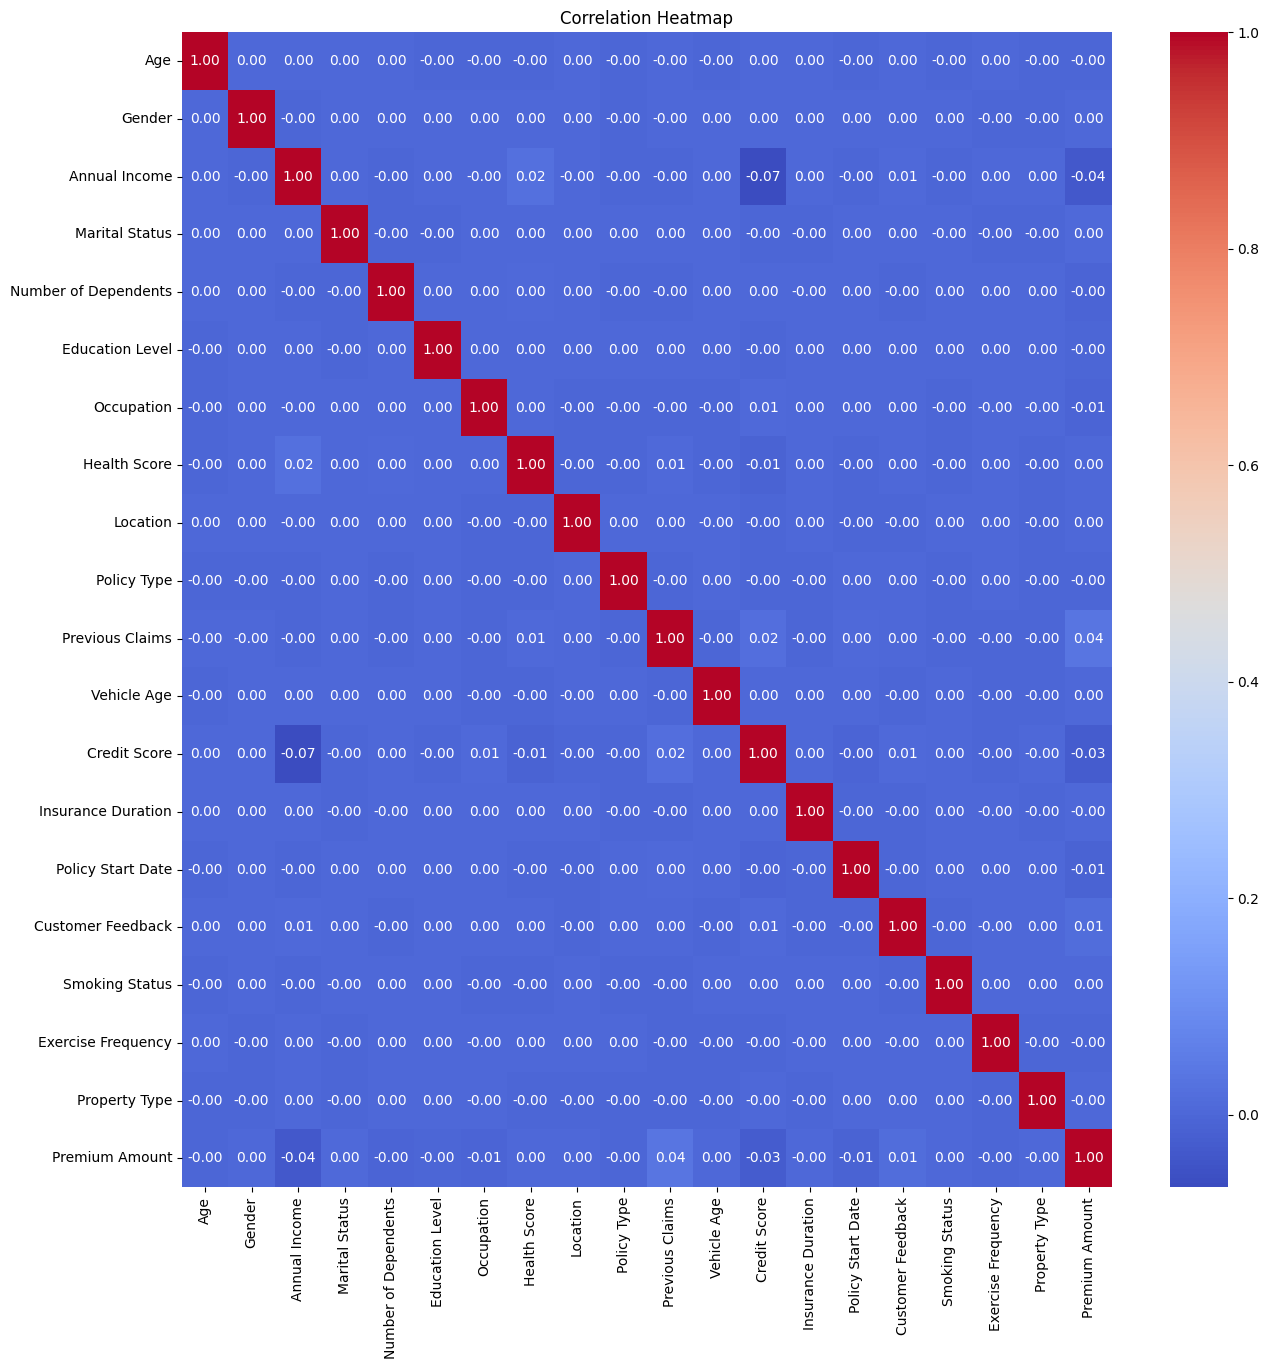

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns


correlation_matrix = train.corr(method="spearman")

# Plot Heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

In [9]:
from ktools.modelling.ktools_models.lgbm_model import LGBMModel


important_feats = ['Gender',
  'Annual Income',
  'Marital Status',
  'Number of Dependents',
  'Occupation',
  'Health Score',
  'Location',
  'Policy Type',
  'Previous Claims',
  'Credit Score',
  'Insurance Duration',
  'Customer Feedback',
  'Smoking Status',
  'Property Type']

kf = KFold(5, shuffle=True, random_state=42)

params = {"boosting_type" : "gbdt", "num_boost_round" : 10000, "early_stopping_rounds" : 200,
            "data_sample_strategy" : "goss", 'num_leaves': 88, 'max_depth': 25, 'learning_rate': 0.018323657940881904, 'subsample': 0.6482084267161204, 'colsample_bytree': 0.7620127668184757, 'reg_alpha': 3.74945058358028e-06, 'reg_lambda': 2.338143768891759e-06, 'min_data_in_leaf': 56, 'feature_fraction': 0.9649659501600546, 'max_bin': 2064, 'min_child_weight': 0.012495041049411066, 'scale_pos_weight': 6.913196143920099, 'cat_smooth': 79.86768177281307}
cve = CrossValidationExecutor(LGBMModel(),
                            root_mean_squared_error,
                            kf,
                            verbose=2
                            ).run(X[important_feats],
                                    np.log1p(y))


The CV results of the current fold is 1.0500455539599758
The CV results of the current fold is 1.0499040685772982
The CV results of the current fold is 1.0502095042234454
The CV results of the current fold is 1.0484650456697233
The CV results of the current fold is 1.0497703124223359
####################################################################################################
OOF prediction score :  1.049679082596394
Mean 5-cv results : 1.0496788969705555 +- 0.0006242556243317956
####################################################################################################


In [10]:
cve = CrossValidationExecutor(LGBMModel(),
                            root_mean_squared_error,
                            kf,
                            verbose=2
                            ).run(X,
                                    np.log1p(y))

The CV results of the current fold is 1.0521616999198808
The CV results of the current fold is 1.0520155872467463
The CV results of the current fold is 1.052189682882966
The CV results of the current fold is 1.0504953981901624
The CV results of the current fold is 1.0522515975769116
####################################################################################################
OOF prediction score :  1.0518230054125681
Mean 5-cv results : 1.0518227931633335 +- 0.0006682044678851622
####################################################################################################


In [30]:
from ktools.hyperparameter_optimization.recursive_feature_elimination_executor import RecursiveFeatureEliminationExecutor
from ktools.modelling.ktools_models.lgbm_model import LGBMModel


kf = KFold(5, shuffle=True, random_state=42)

params = {"boosting_type" : "gbdt", "num_boost_round" : 10000, "early_stopping_rounds" : 200,
            "data_sample_strategy" : "goss", 'num_leaves': 88, 'max_depth': 25, 'learning_rate': 0.018323657940881904, 'subsample': 0.6482084267161204, 'colsample_bytree': 0.7620127668184757, 'reg_alpha': 3.74945058358028e-06, 'reg_lambda': 2.338143768891759e-06, 'min_data_in_leaf': 56, 'feature_fraction': 0.9649659501600546, 'max_bin': 2064, 'min_child_weight': 0.012495041049411066, 'scale_pos_weight': 6.913196143920099, 'cat_smooth': 79.86768177281307}
cve = CrossValidationExecutor(LGBMModel(**{'objective': 'regression', 'metric': 'rmse', **params}),
                            root_mean_squared_error,
                            kf,
                            verbose=2
                            )

_ = create_oofs_from_model(cve,
                       X,
                       np.log1p(y),
                       test_df,
                    #    additional_data=[Xog, yog],
                     #   output_transform_list=[lambda y : np.expm1(y)],
                       model_string="scriptchef_lgb_goss",
                       directory_path="data/insurance/oofs/",
                       sample_submission_file=sample_sub_csv_path)
# RecursiveFeatureEliminationExecutor(cve,
#                                    settings.training_col_names,
#                                    verbose=True).run(X, np.log1p(y))

The CV results of the current fold is 1.0460214101506264
The CV results of the current fold is 1.044980268525065
The CV results of the current fold is 1.045897372944772
The CV results of the current fold is 1.0437839572181749
The CV results of the current fold is 1.0455563539701374
####################################################################################################
OOF prediction score :  1.0452481911494855
Mean 5-cv results : 1.045247872561755 +- 0.0008160921494385286
####################################################################################################


In [67]:
# train = train_df[train_df['source'] == 0]
# original = train_df[train_df['source'] == 1]

# train.drop(columns='source', inplace=True)
# original.drop(columns='source', inplace=True)
# test_df.drop(columns='source', inplace=True)

X, y = train.drop(columns=target_col_name), train[[target_col_name]]
# Xog, yog = original.drop(columns=target_col_name), original[[target_col_name]]

In [7]:
class FE:
    def create(self, df):
        df['year_num'] = pd.to_datetime(df['Policy Start Date']).dt.year
        df['month_num'] = pd.to_datetime(df['Policy Start Date']).dt.month
        df['day_num'] = pd.to_datetime(df['Policy Start Date']).dt.day
        return df, ['year_num', 'month_num', 'day_num']

In [12]:
from ktools.experimentation.robust_feature_importance_checker import RobustFeatureImportanceChecker

kf = KFold(5, shuffle=True, random_state=42)
RobustFeatureImportanceChecker(train_csv_path,
                               test_csv_path,
                               target_col_name,
                               FE(),
                               kf,
                               root_mean_squared_error,
                               "minimize",
                               initial_transform_list = [
                                                         LogTransformTarget.transform,
                                                         FillNullValues.transform, 
                                                         ConvertObjectToCategorical.transform],
                               result_path="./ktools/experimentation/Tests/TestData/insurance").run()

Initial population found
####################################################################################################
OOF prediction score :  1.048552032423671
Mean 5-cv results : 1.0485513334294905 +- 0.001210728313149108
####################################################################################################
####################################################################################################
OOF prediction score :  1.0485028176492621
Mean 5-cv results : 1.048499966582391 +- 0.0024451370445093077
####################################################################################################
####################################################################################################
OOF prediction score :  1.0484850083611224
Mean 5-cv results : 1.0484834234727571 +- 0.001823036168112423
####################################################################################################
####################################################

In [57]:
params = {
            'task_type'           : "CPU",
            'loss_function'       : 'RMSE',
            'eval_metric'         : "MSLE",
            'bagging_temperature' : 0.25,
            'colsample_bylevel'   : 0.40,
            'num_boost_round'     : 1_000,
            'learning_rate'       : 0.045,
            'max_depth'           : 7,
            'l2_leaf_reg'         : 0.80,
            'min_data_in_leaf'    : 30,
            'random_strength'     : 0.25,
            'random_state'        : 42,
            'early_stopping_rounds': 200,
            'use_best_model'       : True,
            'grow_policy' : "SymmetricTree"
}

cat_model = CatBoostModel(loss_function= 'RMSE', eval_metric = "MSLE", predict_type='regression') #**params,

kf = KFold(10, shuffle=True, random_state=42)

cve = CrossValidationExecutor(cat_model,
                            root_mean_squared_error,
                            kf,
                            verbose=2
                            )

_ = create_oofs_from_model(cve,
                       X,
                       np.log1p(y),
                       test_df,
                    #    additional_data=[Xog, yog],
                     #   output_transform_list=[lambda y : np.expm1(y)],
                       model_string="scriptchef_cat_log_trans",
                       directory_path="data/insurance/oofs/",
                       sample_submission_file=sample_sub_csv_path)

The CV results of the current fold is 1.0648068554999834
The CV results of the current fold is 1.064895320955937
The CV results of the current fold is 1.065316317695638
The CV results of the current fold is 1.0618441866332387
The CV results of the current fold is 1.0670106133147839
The CV results of the current fold is 1.062308127559061
The CV results of the current fold is 1.0635678468736538
The CV results of the current fold is 1.0635476290073498
The CV results of the current fold is 1.0606245236936498
The CV results of the current fold is 1.0694054740728558
####################################################################################################
OOF prediction score :  1.0643354920635422
Mean 10-cv results : 1.064332689530615 +- 0.0024424706077362385
####################################################################################################


In [60]:
# df = pd.read_csv('scriptchef_cat_log_trans_submission.csv', index_col=0)
# df['Premium Amount'] = np.expm1(df['Premium Amount'])

In [34]:
df = pd.read_csv('data/insurance/sample_submission.csv')
df['Premium Amount'] = np.expm1(pd.read_csv('scriptchef_lgb_goss_submission.csv')['Premium Amount'].values)
df

,id,Premium Amount
0,1200000,775.833093
1,1200001,811.322685
2,1200002,799.832920
3,1200003,805.453394
4,1200004,745.484683
...,...,...
799995,1999995,967.587525
799996,1999996,591.833587
799997,1999997,840.695675
799998,1999998,813.344425


In [35]:
df.to_csv('scriptchef_lgb_goss_submission.csv', index=False)